## Einstein Summation Convention

Reference: 

https://numpy.org/doc/stable/reference/generated/numpy.einsum.html

https://www.dr-qubit.org/teaching/summation_delta.pdf

In [5]:
import numpy as np 
from scipy.stats import beta, bernoulli, norm 

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

from utils.viz import viz 
viz.get_style()

### Brief introduction

The Einstein summation convention, proposed by Einstein in 1916, significantly simplifies the manipulation expressions of vectors, matrices, and tensors. We can reduce many summation expressions $\sum$ from the equations by applying the convention.

The rules of the summation convention are:

1. Each index can appear at most twice in a term.
2. The repeated indices (in rule 1) are implicitly summed over.
3. Each term must contain identical non-repeated indices. 

Another advantage of using this convention is that all quantities in the output expression become scalars, which allows to reorder the matices and tenosrs.

A valid example:

$$M_{ij} v_j = \sum_i M_{ij} v_i$$

An invalid example:

$$M_{ij} \mu_j v_j +  w_i$$

The index "j" in the first term has more than two repetitions. 

Another invalid example:

$$M_{ijk}u_k + T_{ip}$$

The output of the first term has indices $i,j$ and the second term has $i, p$. This violates the three rule. 




### Psychological application

According to my knowledge, this convention might be applied to two main domains: neural-network-based models and hierarchical Bayesian models. Let's see an example of the hierarchical model (Brehens, 2007)[https://www.nature.com/articles/nn1954].

This paper, aim at solving a probability tracking task

In [52]:
def get_data( n_trials=300):
    p_blue = np.zeros( n_trials)
    for i in range(n_trials):
        if i<120:
            p_blue[i] = 0.75
        elif i<160:
            p_blue[i] = 0.2
        elif i<200:
            p_blue[i] = 0.8
        elif i<230:
            p_blue[i] = 0.2
        elif i<260:
            p_blue[i] = 0.8
        else:
            p_blue[i] = 0.2
    blue_seen = np.zeros(n_trials)
    for i in range(n_trials):
        rand=np.random.rand(1)
        if rand < p_blue[i]:
            blue_seen[i] = 1

    return blue_seen, p_blue



The inference problem in a volatile environment is defined as,  

$$
\begin{aligned}
&p(\text{v}_t,\text{r}_t|\text{y}_{1:t})\\
=&\sum_k p(\text{v}_t,\text{r}_t,k|\text{y}_{1:t},k)\\
=&\sum_k p(\text{v}_t,\text{r}_t|\text{y}_{1:t},k)p(k)\\
=&\sum_k p(\text{v}_t,\text{r}_t|\text{y}_{1:t-1}, \text{y}_t,k)p(k)\\
\propto&\sum_k p(\text{v}_t,\text{r}_t, \text{y}_t|\text{y}_{1:t-1},k)p(k)\\
=& \sum_k p(\text{y}_t|\text{v}_t,\text{r}_t,\text{y}_{1:t-1},k)p(\text{v}_t,\text{r}_t |\text{y}_{1:t-1})p(k|\text{y}_{1:t-1})p(k)\\
=& \sum_k p(\text{y}_t|\text{v}_t,\text{r}_t,\text{y}_{1:t-1},k)p(\text{v}_t,\text{r}_t |\text{y}_{1:t-1},k)p(k)\\
=& p(\text{y}_t|\text{r}_t)\sum_i\sum_j\sum_kp(k)p(\text{v}_t,\text{r}_t, \text{v}_{t-1}=i, \text{r}_{t-1}=j |\text{y}_{1:t-1},k)\\
=& p(\text{y}_t|\text{r}_t)\sum_i\sum_j\sum_k p(k)p(\text{v}_t,\text{r}_t| \text{v}_{t-1}=i, \text{r}_{t-1}=j,\text{y}_{1:t-1},k)p(\text{v}_{t-1}=i, \text{r}_{t-1}=j |\text{y}_{1:t-1},k)\\
=& p(\text{y}_t|\text{r}_t)\sum_i\sum_j\sum_k p(k)p(\text{v}_t,\text{r}_t| \text{v}_{t-1}=i, \text{r}_{t-1}=j,k)\delta_{t-1}(i,j,k)\\
=& p(\text{y}_t|\text{r}_t)\sum_i\sum_j\sum_k p(k)p(\text{v}_t,\text{r}_t| \text{v}_{t-1}=i, \text{r}_{t-1}=j,k)\delta_{t-1}(i,j,k)\\
=& p(\text{y}_t|\text{r}_t)\sum_i\sum_j\sum_k p(k)p(\text{v}_t| \text{v}_{t-1}=i, \text{r}_{t-1}=j,k) p(\text{r}_t|\text{v}_t,\text{v}_{t-1}=i, \text{r}_{t-1}=j,k)\delta_{t-1}(i,j,k)\\
=& p(\text{y}_t|\text{r}_t)\sum_i\sum_j\sum_k p(k)p(\text{v}_t| \text{v}_{t-1}=i,k) p(\text{r}_t|\text{v}_t,\text{r}_{t-1}=j)\delta_{t-1}(i,j,k)\\
\end{aligned}
$$

We can recognize the recursive equation, 

$$\delta_t(i,j,k) = p(\text{y}_t|\text{r}_t)\sum_i\sum_jp(\text{v}_t| \text{v}_{t-1}=i,k) p(\text{r}_t|\text{v}_t,\text{r}_{t-1}=j)\delta_{t-1}(i,j,k)$$

Hence, we can build a model

In [6]:
def rbeta( r, v):
    '''Reparameterized beta
    r = a / (a+b)
    v = -log(a+b)
    '''
    a = r*np.exp(-v)
    b = np.exp(-v)*(1-r)
    return beta( a, b)

class BayesLearner():

    def __init__( self):
        self._discretize()
        self._init_p_K()
        self._init_p_V1VK()
        self._init_p_R1VR()
        self._init_delta()

    def _discretize( self,):
        '''Discretize all variables
            r: reward probability
            v: the volatility
            k: the variance of volatitity
            Default dim convention:
            dim: yt, vt, rt, vt-1, rt-1, k
        '''
        # get discerete space 
        self.n_split = 50 
        self.r_space = np.linspace( .01, .99, self.n_split)
        self.v_space = np.linspace( -11,  -2, self.n_split)
        self.k_space = np.linspace(  -2,   2, self.n_split)

    def _init_p_K( self,):
        '''p(K) = Uniform 
        '''
        self.p_K = np.ones_like([self.k_space]) / self.n_split

    def _init_p_V1VK( self,):
        '''p(Vt|Vt-1=i,k) = N( i, exp(k))
        '''
        p_V1VK = np.zeros( [ self.n_split, self.n_split, self.n_split])
        for i, vi in enumerate( self.v_space):
            for k, kk in enumerate( self.k_space):
                p_V1VK[ :, i, k] = norm.pdf( self.v_space, loc=vi, scale=np.exp(kk))
        p_V1VK /= p_V1VK.sum(0,keepdims=True)
        self.p_V1VK = p_V1VK

    def _init_p_R1VR( self,):
        '''p(Rt|Vt-1=i,Rt-1=j) = rBeta(j,i)
        '''
        p_R1VR = np.zeros( [ self.n_split, self.n_split, self.n_split])
        for j, rj in enumerate( self.r_space):
            for i, vi in enumerate( self.v_space):
                p_R1VR[ :, i, j] = rbeta( rj, vi).pdf(self.r_space)
        p_R1VR /= p_R1VR.sum(0,keepdims=True)
        self.p_R1VR = p_R1VR

    def _init_delta( self,):
        '''δ0(vi,rj,kk)
            Init with Perks prior 
        '''
        f_VRK =  np.ones( [ self.n_split, self.n_split, self.n_split])
        self.delta = f_VRK / f_VRK.sum()
        
    def update( self, y):
        '''update δ with y 
        '''
        # get p(yt|rt): dim: rt
        p_y1r = bernoulli.pmf( y, self.r_space)
        # ∑i p(vt|vt-1=i, k) δ(i,rt-1,k)
        # dim: vt vt-1 @ vt-1, rt-1 --> vt, rt-1
        delta1 = np.zeros( [self.n_split]*3) 
        for k in range(self.n_split):
            delta1[:,:,k] = self.p_V1VK[:,:,k] @ self.delta[:,:,k]
        # ∑j p(rt|vt, rt-1=j) δ(vt,j,k)
        # dim:  rt rt-1 @ rt-1, k = rt k 
        delta2 = np.zeros( [self.n_split]*3) 
        for i in range(self.n_split):
            delta2[i,:,:] = self.p_R1VR[:,i,:]@delta1[i,:,:]
        # δ(vt,j,k) * p(y|rt=j)
        # get new delta: vt, rt, k
        delta = p_y1r[ np.newaxis, :, np.newaxis] * delta2
        self.delta = delta / delta.sum()
        # get some prediction
        self.p_V   = (self.delta.sum(axis=(1,2))*self.v_space).sum()
        self.p_R   = (self.delta.sum(axis=(0,2))*self.r_space).sum()

In [53]:
def sim(agent):
    '''Simulate the experiment
    '''
    data, pTrue = get_data()
    model = agent()
    pVs, pRs = [], []
    # start simulte
    for y in data:
        model.update(y)
        pVs.append( model.p_V.copy())
        pRs.append( model.p_R.copy())
    
    fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12, 6))
    ax1.plot( data,'go',label='noisy observations')
    ax1.plot( pTrue,color=viz.Blue,label='true reward rate')
    ax1.plot( pRs,color=viz.Red,label='estimated reward rate')
    ax1.legend()
    ax2.plot( pVs,'k',label='estimated volatility')
    ax2.legend()
    fig.tight_layout()

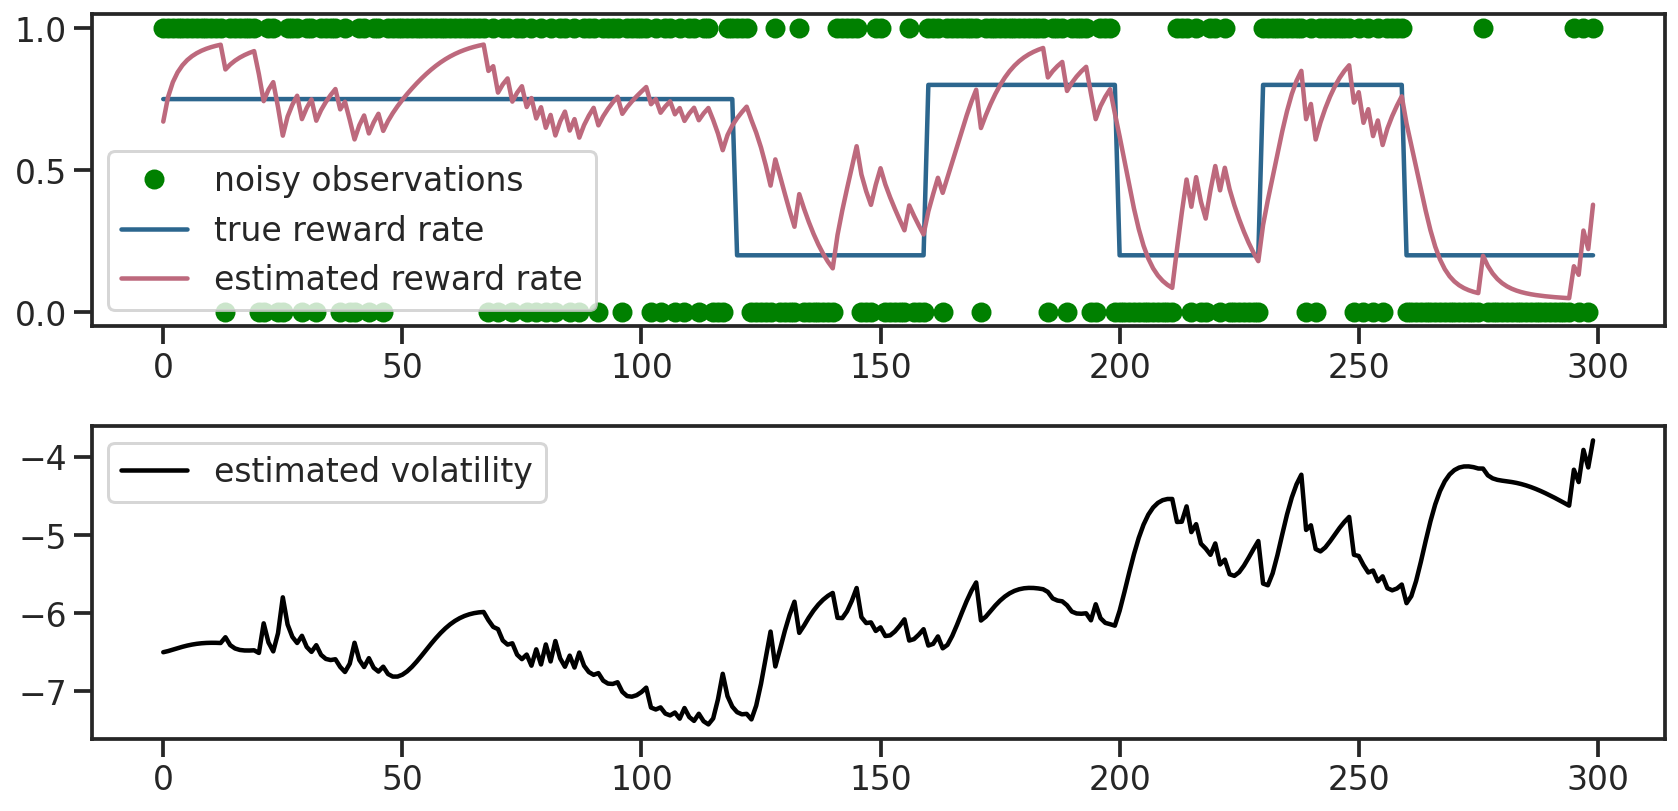

In [57]:
np.random.seed(1)
sim(BayesLearner)

Now we reduce the loop using einsten summation convention

In [55]:
class BL2(BayesLearner):

    def update( self, y):
        '''update δ with y 
        '''
        # get p(yt|rt): dim: rt
        p_y1r = bernoulli.pmf( y, self.r_space)
        # ∑i p(vt|vt-1=i, k) δ(i,rt-1,k) = Pvi..., δir... --> D...vr
        # dim: vt vt-1 @ vt-1, rt-1 --> vt, rt-1
        delta1 = np.einsum('vi..., ir...->vr...', self.p_V1VK, self.delta)
        # ∑j p(rt|vt, rt-1=j) δ(vt,j,k) = Pr...j, δ...jk --> D...rk
        # dim:  rt rt-1 @ rt-1, k = rt k 
        delta2 = np.einsum('r...j, ...jk->...rk', self.p_R1VR, delta1)
        # get new delta: vt, rt, k
        delta = p_y1r[ np.newaxis, :, np.newaxis] * delta2
        self.delta = delta / delta.sum()
        # get some prediction
        self.p_V   = (self.delta.sum(axis=(1,2))*self.v_space).sum()
        self.p_R   = (self.delta.sum(axis=(0,2))*self.r_space).sum()

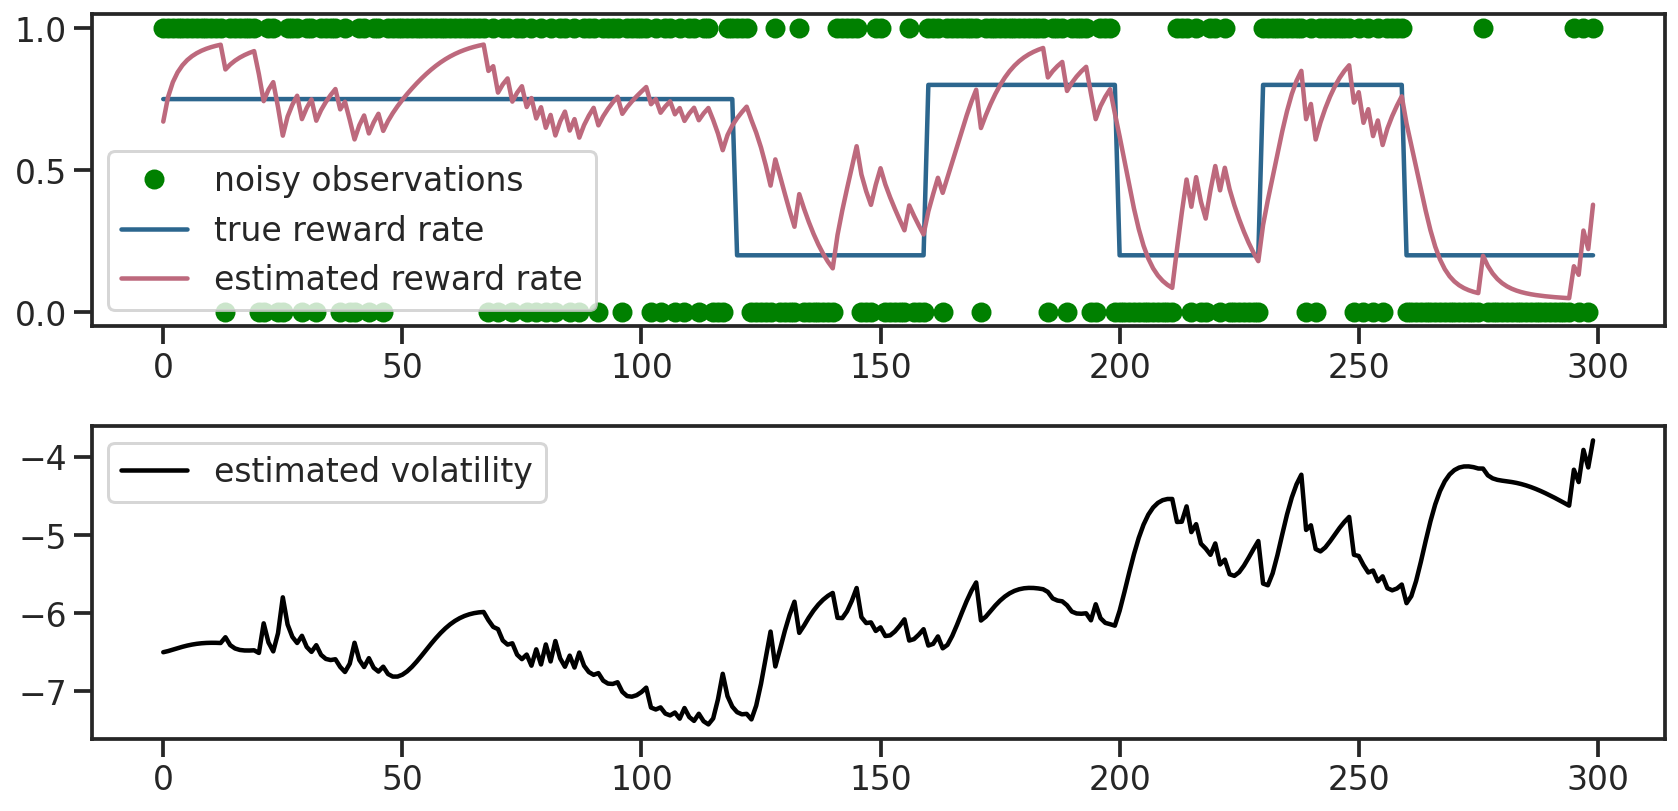

In [58]:
np.random.seed(1)
sim(BL2)

Model 1 and 2 are equivalent. However, the Einstein summation convention simplify our code, making it concise and elegant. 